In [39]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import DataLoader

In [40]:
torch.cuda.is_available()

True

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

#print(device)

In [42]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [43]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


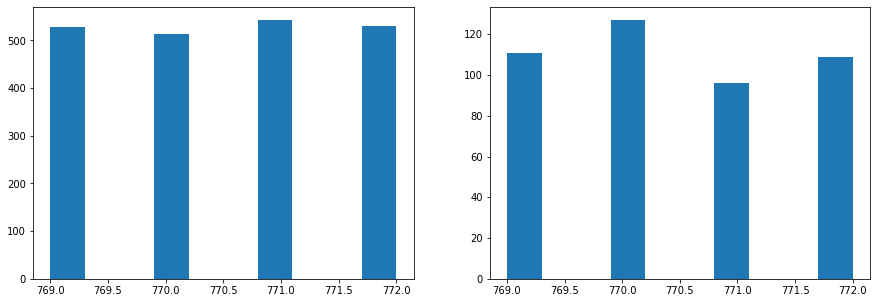

In [44]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train_valid)
plt.subplot(1, 2, 2)
plt.hist(y_test)
y_train_valid -= 769
y_test -= 769

In [45]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [46]:
#Read trainingdata for one subject and sample them

def double_ax2(a):
    result = np.zeros((a.shape[0],a.shape[1],a.shape[2] * 2))
    b = np.reshape(a[:,:,-1],(a.shape[0],a.shape[1],1))
    aMod = np.concatenate((a,b),axis = 2)
    for i in range(a.shape[2]):
        ave = (aMod[:,:,i] + aMod[:,:,i+1]) / 2
        result[:,:,2 * i] = aMod[:,:,i]
        result[:,:,2*i + 1] = ave
    return result
#-------------------------------------------------------------------------------------------------------------
X_train_valid_1 = X_train_valid[np.where(person_train_valid==1)[0]]
y_train_valid_1 = y_train_valid[np.where(person_train_valid==1)[0]]
X_test_1 = X_test[np.where(person_test==1)[0]]
y_test_1 = y_test[np.where(person_test==1)[0]]
#--------------------------------------------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_valid_1, y_train_valid_1,
#                                                              test_size=0.2,shuffle=True,stratify=y_train_valid_1)

#print(X_train_1.shape)

num_time = X_train_valid_1.shape[2]
sample_1 = list(np.arange(0,num_time,2))
sample_2 = list(np.arange(1,num_time,2))

X_tr_1 = X_train_valid_1[:,:,sample_1]
X_tr_2 = X_train_valid_1[:,:,sample_2]
#X_test_s1 = X_test[:,:,sample_1]
#X_test_s2 = X_test[:,:,sample_2]
print('X_tr_1,  ',X_tr_1.shape)

#X_train_s = X_tr_1   
X_train_s = np.concatenate((X_tr_1,X_tr_2), axis=0)  
#y_train_s = y_train_1  
y_train_s = np.concatenate((y_train_valid_1,y_train_valid_1), axis=0) 
print('X_train_s  ',X_train_s.shape)
X_train_s_x2 = double_ax2(X_train_s)
print(X_train_s_x2.shape)
X_train_s = np.concatenate((X_train_valid_1,X_train_s_x2), axis=0)
print(X_train_s.shape)

y_train_s = np.concatenate((y_train_valid_1,y_train_s), axis=0)
print(y_train_s.shape)

#person_train_valid_s = np.concatenate((person_train_valid,person_train_valid,person_train_valid), axis=0)
#person_test_s = person_test
#X_test_s = np.concatenate((X_test_s1,X_test_s2), axis=0)
X_test_s = X_test_1
#X_test_s1
#y_test_s = np.concatenate((y_test,y_test), axis=0)
y_test_s = y_test_1
#y_test
#person_test_s = np.concatenate((person_test,person_test), axis=0)

print(X_train_s.shape)
print(y_train_s.shape)
print(X_test_s.shape)
#print(person_train_s.shape)
#print(person_test.shape)
X_train_s = X_train_s.transpose(0,2,1)
#X_valid_1 = X_valid_1.transpose(0,2,1)
X_test_1 = X_test_1.transpose(0,2,1)

train_set_1 = Dataset(X_train_s,y_train_s)
#val_set_1 = Dataset(X_valid_1,y_valid_1)
test_set_1 = Dataset(X_test_1, y_test_1)

train_loader_1 = torch.utils.data.DataLoader(train_set_1,batch_size=72,shuffle=True)
#val_loader_1 = torch.utils.data.DataLoader(val_set_1,batch_size=8,shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_set_1,batch_size=10,shuffle=False)

X_tr_1,   (236, 22, 500)
X_train_s   (472, 22, 500)
(472, 22, 1000)
(708, 22, 1000)
(708,)
(708, 22, 1000)
(708,)
(50, 22, 1000)


In [47]:
print(X_train_s.shape[0])
for i, data in enumerate(train_loader_1):
    print(data[0].shape, data[1].shape)
    if i == 2:
        break

708
torch.Size([72, 1000, 22]) torch.Size([72])
torch.Size([72, 1000, 22]) torch.Size([72])
torch.Size([72, 1000, 22]) torch.Size([72])


In [48]:
data[0].shape

torch.Size([72, 1000, 22])

In [49]:
# [conv-relu]*2 -> 2*2 avg-pooling -> [conv-relu]*3 -> 2*2 avg_pooling -> (affine-relu)*2 -> affine -> softmax
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()  # initial the model
        self.conv1 = nn.Conv1d(22,40,kernel_size = 2,stride = 2) 
        self.bn1 = nn.BatchNorm1d(40)
        self.conv2 = nn.Conv1d(40,60,kernel_size = 3,stride = 1) 
        self.bn2 = nn.BatchNorm1d(60) 
        self.pool1 = nn.AvgPool1d(2,2) 
        
        self.conv3 = nn.Conv1d(60,80,kernel_size = 3, stride = 1) 
        self.bn3 = nn.BatchNorm1d(80)
        self.conv4 = nn.Conv1d(80,100,kernel_size = 3, stride = 1) 
        self.bn4 = nn.BatchNorm1d(100)
        self.conv5 = nn.Conv1d(100,120,kernel_size = 3, stride = 2) #120*122
        self.bn5 = nn.BatchNorm1d(120)
        self.pool2 = nn.AvgPool1d(2,2) #120*61
        
        self.fc1 = nn.Linear(120*61, 300) # input dim , output dim
        self.bn6 = nn.BatchNorm1d(300)
        self.drop1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(300,40)  
        self.bn7 = nn.BatchNorm1d(40)
        self.drop2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(40,4)
 
    def forward(self,x):
        x = x.permute(0,2,1) 
        #x = torch.Tensor(x.numpy().transpose(0,2,1))
        x = self.pool1(F.elu(self.bn2(self.conv2(F.elu(self.bn1(self.conv1(x)))))))
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool2(F.elu(self.bn5(self.conv5(x))))
        x = x.view(-1,120*61)
        
        x = self.drop1(F.elu(self.bn6(self.fc1(x))))
        x = self.drop2(F.elu(self.bn7(self.fc2(x))))
        x = self.fc3(x)
        return x
net = Net()
print(net)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.001)

Net(
  (conv1): Conv1d(22, 40, kernel_size=(2,), stride=(2,))
  (bn1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(40, 60, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv3): Conv1d(60, 80, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(80, 100, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(100, 120, kernel_size=(3,), stride=(2,))
  (bn5): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=7320, out_features=300, bias=True)
  (bn6): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, t

**CNN投票**

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_1 = Net()
net_2 = Net()
net_3 = Net()
net_4 = Net()
net_5 = Net()
net_6 = Net()
net_7 = Net()
list_net = [net_1, net_2, net_3, net_4, net_5, net_6, net_7]
#list_best_net = [Net(), Net(), Net(), Net(), Net(), Net(), Net()]
for n,net in enumerate(list_net):
    
    net.to(device)
    
    #val_acc_history = []
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.001)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = 0.9, nesterov = True, weight_decay = 1e-3)

    print('--------------------------------------------------')
    print('Training Net {}'.format(n+1))
    for epoch in range(35): #Single subject
    #for epoch in range(35):#All subjects
        for i , data in enumerate(train_loader_1, 0):
            
            inputs, labels = data[0].to(device), data[1].to(device)
            
            #inputs, labels = data
            
            net.train()
            
            optimizer.zero_grad()
    
            outputs = net(inputs)
            reg_loss = 0
            for param in net.parameters():
                reg_loss += nn.MSELoss(reduction='sum')(param,target=torch.zeros_like(param))
            factor = 1e-3
            loss = criterion(outputs, labels)
            loss += factor*reg_loss
            loss.backward()
            optimizer.step()
            
            _,predicted = torch.max(outputs.data, 1)
            train_acc = (predicted == labels).sum().item() / len(labels)
            
            if i % 2 == 1:
                net.eval()
                test_correct, test_total = 0, 0 
                for test_data in test_loader_1:
                    
                    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
                    
                    #test_images, test_labels = test_data
                    
                    test_outputs = net(test_images)
                    _, test_predicted = torch.max(test_outputs.data, 1)
                    test_total += test_labels.size(0)
                    test_correct += (test_predicted == test_labels).sum().item()
                test_acc = test_correct / test_total
                print('Epoch {} | Iter{} | Loss{:.4f} | TrainAcc{:.4f} | Testacc {:.4f}'.format(
                    epoch+1, i , loss, train_acc, test_acc))
                #writer.add_scalar('Train/Loss',loss,epoch*len(trainloader) + i)
                #writer.add_scalar('Train/ACC',train_acc,epoch*len(trainloader) + i)
                #writer.add_scalar('VAL/ACC',val_acc,epoch*len(trainloader) + i)
        #net.eval()
        #val_correct, val_total = 0, 0
        #for val_data in val_loader_1:
        #    val_images, val_labels = val_data
        #    val_outputs = net(val_images)
        #    _, val_predicted = torch.max(val_outputs.data, 1)
        #    val_total += val_labels.size(0)
        #    val_correct += (val_predicted == val_labels).sum().item()
        #val_acc = val_correct / val_total
        #val_acc_history.append(val_acc)
        #if val_acc == max(val_acc_history):
        #    list_best_net[n] = Net()
        #    list_best_net[n].load_state_dict(net.state_dict())
    net.eval()
    test_correct, test_total = 0, 0
    for test_data in test_loader_1:
        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
        test_outputs = net(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()
    test_acc = test_correct / test_total
    print('Test accuracy of model {}: '.format(n+1),test_acc)
    
test_correct, test_total = 0, 0
device = torch.device("cpu")
for test_data in test_loader_1:
    test_images, test_labels = test_data
    test_predicted_list = []
    for net in list_net:
    #for net_best in list_best_net:
        net.to(device)
        net.eval()
        test_outputs = net(test_images)
        #test_outputs = net_best(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_predicted_list.append(test_predicted.numpy())
    test_predicted_list = np.array(test_predicted_list)
    test_predicted_result = []
    for vote in range(np.shape(test_predicted_list)[1]):
        test_predicted_result.append(Counter(test_predicted_list[:,vote]).most_common(1)[0][0])
    test_predicted = torch.Tensor(test_predicted_result)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)



--------------------------------------------------
Training Net 1
Epoch 1 | Iter1 | Loss2.7302 | TrainAcc0.2917 | Testacc 0.2400
Epoch 1 | Iter3 | Loss2.6363 | TrainAcc0.3056 | Testacc 0.2400
Epoch 1 | Iter5 | Loss2.6781 | TrainAcc0.3333 | Testacc 0.2600
Epoch 1 | Iter7 | Loss2.5519 | TrainAcc0.3194 | Testacc 0.3000
Epoch 1 | Iter9 | Loss2.5456 | TrainAcc0.2833 | Testacc 0.3200
Epoch 2 | Iter1 | Loss2.6045 | TrainAcc0.3333 | Testacc 0.3600
Epoch 2 | Iter3 | Loss2.5562 | TrainAcc0.3056 | Testacc 0.3400
Epoch 2 | Iter5 | Loss2.3187 | TrainAcc0.3750 | Testacc 0.3000
Epoch 2 | Iter7 | Loss2.3908 | TrainAcc0.3056 | Testacc 0.3200
Epoch 2 | Iter9 | Loss2.4018 | TrainAcc0.4333 | Testacc 0.3200
Epoch 3 | Iter1 | Loss2.2943 | TrainAcc0.4306 | Testacc 0.3600
Epoch 3 | Iter3 | Loss2.3769 | TrainAcc0.3611 | Testacc 0.3800
Epoch 3 | Iter5 | Loss2.3994 | TrainAcc0.4028 | Testacc 0.3600
Epoch 3 | Iter7 | Loss2.3658 | TrainAcc0.3333 | Testacc 0.4000
Epoch 3 | Iter9 | Loss2.2462 | TrainAcc0.4000 | Test

Epoch 26 | Iter7 | Loss1.3665 | TrainAcc0.8750 | Testacc 0.5000
Epoch 26 | Iter9 | Loss1.3998 | TrainAcc0.9000 | Testacc 0.5400
Epoch 27 | Iter1 | Loss1.3038 | TrainAcc0.9306 | Testacc 0.5400
Epoch 27 | Iter3 | Loss1.3159 | TrainAcc0.9167 | Testacc 0.5200
Epoch 27 | Iter5 | Loss1.4323 | TrainAcc0.8472 | Testacc 0.5000
Epoch 27 | Iter7 | Loss1.3861 | TrainAcc0.8611 | Testacc 0.5200
Epoch 27 | Iter9 | Loss1.3493 | TrainAcc0.9333 | Testacc 0.5200
Epoch 28 | Iter1 | Loss1.3051 | TrainAcc0.9028 | Testacc 0.5200
Epoch 28 | Iter3 | Loss1.3386 | TrainAcc0.8611 | Testacc 0.4800
Epoch 28 | Iter5 | Loss1.3469 | TrainAcc0.9167 | Testacc 0.5000
Epoch 28 | Iter7 | Loss1.3815 | TrainAcc0.8611 | Testacc 0.5200
Epoch 28 | Iter9 | Loss1.3488 | TrainAcc0.8833 | Testacc 0.5200
Epoch 29 | Iter1 | Loss1.2434 | TrainAcc0.9861 | Testacc 0.5200
Epoch 29 | Iter3 | Loss1.2977 | TrainAcc0.9444 | Testacc 0.5000
Epoch 29 | Iter5 | Loss1.2878 | TrainAcc0.9306 | Testacc 0.5000
Epoch 29 | Iter7 | Loss1.2647 | TrainAcc

Epoch 17 | Iter3 | Loss1.5783 | TrainAcc0.8194 | Testacc 0.4800
Epoch 17 | Iter5 | Loss1.6693 | TrainAcc0.7083 | Testacc 0.4400
Epoch 17 | Iter7 | Loss1.4776 | TrainAcc0.8472 | Testacc 0.4600
Epoch 17 | Iter9 | Loss1.4691 | TrainAcc0.8833 | Testacc 0.4600
Epoch 18 | Iter1 | Loss1.5026 | TrainAcc0.8333 | Testacc 0.4800
Epoch 18 | Iter3 | Loss1.4491 | TrainAcc0.9167 | Testacc 0.4800
Epoch 18 | Iter5 | Loss1.5663 | TrainAcc0.8056 | Testacc 0.4800
Epoch 18 | Iter7 | Loss1.4753 | TrainAcc0.8611 | Testacc 0.4800
Epoch 18 | Iter9 | Loss1.5103 | TrainAcc0.8500 | Testacc 0.4800
Epoch 19 | Iter1 | Loss1.5104 | TrainAcc0.8472 | Testacc 0.4800
Epoch 19 | Iter3 | Loss1.5768 | TrainAcc0.7639 | Testacc 0.4800
Epoch 19 | Iter5 | Loss1.4414 | TrainAcc0.9028 | Testacc 0.4400
Epoch 19 | Iter7 | Loss1.4024 | TrainAcc0.9167 | Testacc 0.4400
Epoch 19 | Iter9 | Loss1.5141 | TrainAcc0.9000 | Testacc 0.4400
Epoch 20 | Iter1 | Loss1.5010 | TrainAcc0.8750 | Testacc 0.4600
Epoch 20 | Iter3 | Loss1.3619 | TrainAcc

Epoch 7 | Iter7 | Loss1.9298 | TrainAcc0.6250 | Testacc 0.5000
Epoch 7 | Iter9 | Loss1.8630 | TrainAcc0.6333 | Testacc 0.5000
Epoch 8 | Iter1 | Loss1.8531 | TrainAcc0.6667 | Testacc 0.5000
Epoch 8 | Iter3 | Loss1.8327 | TrainAcc0.6944 | Testacc 0.5000
Epoch 8 | Iter5 | Loss1.8468 | TrainAcc0.6806 | Testacc 0.5000
Epoch 8 | Iter7 | Loss1.8332 | TrainAcc0.6944 | Testacc 0.5200
Epoch 8 | Iter9 | Loss1.8708 | TrainAcc0.6667 | Testacc 0.5200
Epoch 9 | Iter1 | Loss1.9037 | TrainAcc0.5694 | Testacc 0.5400
Epoch 9 | Iter3 | Loss1.8022 | TrainAcc0.6667 | Testacc 0.5400
Epoch 9 | Iter5 | Loss1.8153 | TrainAcc0.7361 | Testacc 0.5400
Epoch 9 | Iter7 | Loss1.7876 | TrainAcc0.7222 | Testacc 0.5000
Epoch 9 | Iter9 | Loss1.8842 | TrainAcc0.6000 | Testacc 0.5000
Epoch 10 | Iter1 | Loss1.7302 | TrainAcc0.7222 | Testacc 0.5200
Epoch 10 | Iter3 | Loss1.6944 | TrainAcc0.6806 | Testacc 0.5200
Epoch 10 | Iter5 | Loss1.7603 | TrainAcc0.7361 | Testacc 0.5600
Epoch 10 | Iter7 | Loss1.8266 | TrainAcc0.7361 | Tes

Epoch 33 | Iter5 | Loss1.2477 | TrainAcc0.9306 | Testacc 0.5600
Epoch 33 | Iter7 | Loss1.2694 | TrainAcc0.9167 | Testacc 0.5400
Epoch 33 | Iter9 | Loss1.3426 | TrainAcc0.8167 | Testacc 0.5400
Epoch 34 | Iter1 | Loss1.2115 | TrainAcc0.9306 | Testacc 0.5400
Epoch 34 | Iter3 | Loss1.2327 | TrainAcc0.9306 | Testacc 0.5400
Epoch 34 | Iter5 | Loss1.3217 | TrainAcc0.9444 | Testacc 0.5200
Epoch 34 | Iter7 | Loss1.2710 | TrainAcc0.9306 | Testacc 0.5400
Epoch 34 | Iter9 | Loss1.2910 | TrainAcc0.8833 | Testacc 0.5400
Epoch 35 | Iter1 | Loss1.2638 | TrainAcc0.9306 | Testacc 0.5400
Epoch 35 | Iter3 | Loss1.2866 | TrainAcc0.9028 | Testacc 0.5600
Epoch 35 | Iter5 | Loss1.3311 | TrainAcc0.9028 | Testacc 0.5200
Epoch 35 | Iter7 | Loss1.1545 | TrainAcc0.9722 | Testacc 0.5200
Epoch 35 | Iter9 | Loss1.2677 | TrainAcc0.9333 | Testacc 0.5000
Test accuracy of model 3:  0.5
--------------------------------------------------
Training Net 4
Epoch 1 | Iter1 | Loss2.8514 | TrainAcc0.2639 | Testacc 0.3000
Epoch 1 

Epoch 24 | Iter1 | Loss1.3384 | TrainAcc0.9306 | Testacc 0.5400
Epoch 24 | Iter3 | Loss1.3967 | TrainAcc0.8611 | Testacc 0.5600
Epoch 24 | Iter5 | Loss1.4101 | TrainAcc0.8750 | Testacc 0.5400
Epoch 24 | Iter7 | Loss1.4217 | TrainAcc0.9167 | Testacc 0.5600
Epoch 24 | Iter9 | Loss1.4346 | TrainAcc0.8833 | Testacc 0.5800
Epoch 25 | Iter1 | Loss1.4520 | TrainAcc0.8611 | Testacc 0.6000
Epoch 25 | Iter3 | Loss1.3761 | TrainAcc0.9306 | Testacc 0.5800
Epoch 25 | Iter5 | Loss1.4788 | TrainAcc0.8333 | Testacc 0.5800
Epoch 25 | Iter7 | Loss1.4218 | TrainAcc0.8750 | Testacc 0.6000
Epoch 25 | Iter9 | Loss1.2835 | TrainAcc0.9333 | Testacc 0.6000
Epoch 26 | Iter1 | Loss1.3330 | TrainAcc0.9167 | Testacc 0.5800
Epoch 26 | Iter3 | Loss1.4271 | TrainAcc0.8611 | Testacc 0.5800
Epoch 26 | Iter5 | Loss1.4135 | TrainAcc0.9028 | Testacc 0.5800
Epoch 26 | Iter7 | Loss1.2884 | TrainAcc0.9583 | Testacc 0.5600
Epoch 26 | Iter9 | Loss1.3337 | TrainAcc0.9667 | Testacc 0.5600
Epoch 27 | Iter1 | Loss1.3094 | TrainAcc

Epoch 14 | Iter7 | Loss1.5454 | TrainAcc0.8611 | Testacc 0.5000
Epoch 14 | Iter9 | Loss1.6536 | TrainAcc0.7667 | Testacc 0.4800
Epoch 15 | Iter1 | Loss1.6235 | TrainAcc0.7917 | Testacc 0.4800
Epoch 15 | Iter3 | Loss1.5995 | TrainAcc0.8056 | Testacc 0.4800
Epoch 15 | Iter5 | Loss1.5885 | TrainAcc0.8194 | Testacc 0.4600
Epoch 15 | Iter7 | Loss1.6076 | TrainAcc0.8194 | Testacc 0.4600
Epoch 15 | Iter9 | Loss1.5447 | TrainAcc0.8167 | Testacc 0.4800
Epoch 16 | Iter1 | Loss1.6140 | TrainAcc0.8611 | Testacc 0.4600
Epoch 16 | Iter3 | Loss1.4820 | TrainAcc0.8611 | Testacc 0.4600
Epoch 16 | Iter5 | Loss1.5039 | TrainAcc0.8750 | Testacc 0.4600
Epoch 16 | Iter7 | Loss1.6286 | TrainAcc0.7778 | Testacc 0.4600
Epoch 16 | Iter9 | Loss1.6397 | TrainAcc0.8000 | Testacc 0.5000
Epoch 17 | Iter1 | Loss1.6131 | TrainAcc0.7917 | Testacc 0.4600
Epoch 17 | Iter3 | Loss1.4830 | TrainAcc0.8750 | Testacc 0.4800
Epoch 17 | Iter5 | Loss1.4738 | TrainAcc0.9306 | Testacc 0.4800
Epoch 17 | Iter7 | Loss1.6296 | TrainAcc

Epoch 5 | Iter1 | Loss2.1423 | TrainAcc0.4861 | Testacc 0.4400
Epoch 5 | Iter3 | Loss2.2335 | TrainAcc0.4583 | Testacc 0.4600
Epoch 5 | Iter5 | Loss2.2119 | TrainAcc0.5000 | Testacc 0.4600
Epoch 5 | Iter7 | Loss2.1209 | TrainAcc0.4722 | Testacc 0.5000
Epoch 5 | Iter9 | Loss2.1581 | TrainAcc0.4667 | Testacc 0.5400
Epoch 6 | Iter1 | Loss2.0749 | TrainAcc0.5694 | Testacc 0.5400
Epoch 6 | Iter3 | Loss2.0458 | TrainAcc0.5556 | Testacc 0.5000
Epoch 6 | Iter5 | Loss2.1461 | TrainAcc0.4583 | Testacc 0.5000
Epoch 6 | Iter7 | Loss2.0173 | TrainAcc0.5556 | Testacc 0.5200
Epoch 6 | Iter9 | Loss2.1639 | TrainAcc0.4500 | Testacc 0.4800
Epoch 7 | Iter1 | Loss2.0863 | TrainAcc0.5139 | Testacc 0.4800
Epoch 7 | Iter3 | Loss2.0394 | TrainAcc0.5694 | Testacc 0.4600
Epoch 7 | Iter5 | Loss1.9826 | TrainAcc0.6528 | Testacc 0.4600
Epoch 7 | Iter7 | Loss1.9661 | TrainAcc0.6528 | Testacc 0.4600
Epoch 7 | Iter9 | Loss1.9807 | TrainAcc0.6167 | Testacc 0.5000
Epoch 8 | Iter1 | Loss1.9802 | TrainAcc0.5972 | Testacc

Epoch 30 | Iter9 | Loss1.3025 | TrainAcc0.9167 | Testacc 0.4400
Epoch 31 | Iter1 | Loss1.3130 | TrainAcc0.9306 | Testacc 0.4600
Epoch 31 | Iter3 | Loss1.2824 | TrainAcc0.9583 | Testacc 0.4600
Epoch 31 | Iter5 | Loss1.2750 | TrainAcc0.9167 | Testacc 0.4400
Epoch 31 | Iter7 | Loss1.2395 | TrainAcc0.9583 | Testacc 0.4600
Epoch 31 | Iter9 | Loss1.3021 | TrainAcc0.9167 | Testacc 0.4600
Epoch 32 | Iter1 | Loss1.2577 | TrainAcc0.9306 | Testacc 0.4800
Epoch 32 | Iter3 | Loss1.3567 | TrainAcc0.8611 | Testacc 0.4600
Epoch 32 | Iter5 | Loss1.2552 | TrainAcc0.9583 | Testacc 0.4800
Epoch 32 | Iter7 | Loss1.2573 | TrainAcc0.9583 | Testacc 0.4800
Epoch 32 | Iter9 | Loss1.3356 | TrainAcc0.8833 | Testacc 0.4600
Epoch 33 | Iter1 | Loss1.2353 | TrainAcc0.9722 | Testacc 0.4600
Epoch 33 | Iter3 | Loss1.2171 | TrainAcc0.9583 | Testacc 0.4800
Epoch 33 | Iter5 | Loss1.2671 | TrainAcc0.9306 | Testacc 0.4600
Epoch 33 | Iter7 | Loss1.3155 | TrainAcc0.9028 | Testacc 0.4600
Epoch 33 | Iter9 | Loss1.1588 | TrainAcc

Epoch 21 | Iter5 | Loss1.4051 | TrainAcc0.9306 | Testacc 0.5200
Epoch 21 | Iter7 | Loss1.4250 | TrainAcc0.8889 | Testacc 0.5000
Epoch 21 | Iter9 | Loss1.4874 | TrainAcc0.8833 | Testacc 0.5200
Epoch 22 | Iter1 | Loss1.4780 | TrainAcc0.8611 | Testacc 0.5200
Epoch 22 | Iter3 | Loss1.4158 | TrainAcc0.9028 | Testacc 0.5000
Epoch 22 | Iter5 | Loss1.4680 | TrainAcc0.8194 | Testacc 0.5000
Epoch 22 | Iter7 | Loss1.4382 | TrainAcc0.8472 | Testacc 0.5200
Epoch 22 | Iter9 | Loss1.4460 | TrainAcc0.9167 | Testacc 0.5200
Epoch 23 | Iter1 | Loss1.3922 | TrainAcc0.8611 | Testacc 0.5000
Epoch 23 | Iter3 | Loss1.3677 | TrainAcc0.9167 | Testacc 0.5000
Epoch 23 | Iter5 | Loss1.3239 | TrainAcc0.9722 | Testacc 0.5000
Epoch 23 | Iter7 | Loss1.3641 | TrainAcc0.9167 | Testacc 0.5000
Epoch 23 | Iter9 | Loss1.4704 | TrainAcc0.8833 | Testacc 0.4800
Epoch 24 | Iter1 | Loss1.4450 | TrainAcc0.8889 | Testacc 0.5000
Epoch 24 | Iter3 | Loss1.2601 | TrainAcc0.9722 | Testacc 0.4800
Epoch 24 | Iter5 | Loss1.3933 | TrainAcc

**CNN+LSTM投票**

In [51]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()  # initial the model
        self.conv1 = nn.Conv1d(22,40,kernel_size = 2,stride = 2) 
        self.bn1 = nn.BatchNorm1d(40)
        self.conv2 = nn.Conv1d(40,60,kernel_size = 3,stride = 1) 
        self.bn2 = nn.BatchNorm1d(60) 
        self.pool1 = nn.AvgPool1d(2,2) 
 
    def forward(self,x):
        x = x.permute(0,2,1)
        #x = torch.Tensor(x.numpy().transpose(0,2,1))
        x = self.pool1(F.elu(self.bn2(self.conv2(F.elu(self.bn1(self.conv1(x)))))))
        x = x.detach()
        x = x.permute(0,2,1)
        #x = torch.Tensor(x.detach().numpy().transpose(0,2,1))
        return x

In [52]:
conv_net1 = ConvNet()
conv_net2 = ConvNet()
conv_net3 = ConvNet()
conv_net4 = ConvNet()
conv_net5 = ConvNet()
conv_net6 = ConvNet()
conv_net7 = ConvNet()
list_convnet = [conv_net1, conv_net2, conv_net3, conv_net4, conv_net5, conv_net6, conv_net7]
for i,convnet in enumerate(list_convnet):
    pretrained_dict = list_net[i].state_dict()
    convnet_dict = convnet.state_dict()
    pretrained_dict = {k:v for k,v in pretrained_dict.items() if k in convnet_dict}
    convnet_dict.update(pretrained_dict)
    convnet.load_state_dict(convnet_dict)

In [53]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, convnet):
        super(LSTM, self).__init__()
        self.conv = convnet  
        #self.conv = ConvNet()  
        self.LSTM1 = nn.LSTM(input_dim, hidden_dim1, bidirectional = True, num_layers=1, batch_first = True, dropout = 0)
        #self.LSTM2 = nn.LSTM(hidden_dim1*2, hidden_dim2, bidirectional = True, num_layers=1, batch_first = True, dropout = 0)
        self.LSTM3 = nn.LSTM(hidden_dim1*2, hidden_dim3, bidirectional = True, num_layers=2, batch_first = True, dropout = 0.4)
        #self.LSTM4 = nn.LSTM(hidden_dim3*2, hidden_dim4, bidirectional = True, num_layers=1, batch_first = True, dropout = 0)
        self.fc1 = nn.Linear(hidden_dim3*2*249, 2000) 
        self.bn1 = nn.BatchNorm1d(2000)
        self.drop1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(2000,100)
        self.bn2 = nn.BatchNorm1d(100)
        self.drop2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(100,20)
        self.bn3 = nn.BatchNorm1d(20)
        self.drop3 = nn.Dropout(0.8)
        self.fc4 = nn.Linear(20,output_dim)
        
    
    def forward(self, x, h=None, c=None):
        x = self.conv(x)
        if type(h) == type(None) and type(c) == type(None):
            out, (hn, cn) = self.LSTM1(x)
            #out, (hn, cn) = self.LSTM2(out)
            out, (hn, cn) = self.LSTM3(out)
            #out, (hn, cn) = self.LSTM4(out)
        else:
            out, (hn, cn) = self.LSTM1(x, h.detach(), c.detach())
            #out, (hn, cn) = self.LSTM2(out, h.detach(), c.detach())
            out, (hn, cn) = self.LSTM3(out, h.detach(), c.detach())
            #out, (hn, cn) = self.LSTM4(out, h.detach(), c.detach())
        #out = self.drop1(F.elu(self.bn1(self.fc1(out[:, -1, :]))))
        out = out.permute(0,2,1)
        out = self.drop1(F.elu(self.bn1(self.fc1(out.reshape(out.shape[0],-1)))))
        out = self.drop2(F.elu(self.bn2(self.fc2(out))))
        out = self.drop3(F.elu(self.bn3(self.fc3(out))))
        out = self.fc4(out)
        
        return out

In [54]:
input_dim = 60
hidden_dim1 = 40
hidden_dim2 = 60
hidden_dim3 = 80
output_dim = 4
model_1 = LSTM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, conv_net1)
model_2 = LSTM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, conv_net2)
model_3 = LSTM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, conv_net3)
model_4 = LSTM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, conv_net4)
model_5 = LSTM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, conv_net5)
model_6 = LSTM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, conv_net6)
model_7 = LSTM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, conv_net7)
list_model = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

list_model = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
t0 = time.time()
for n, model in enumerate(list_model):
    #val_acc_history = []
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, nesterov = True, weight_decay = 1e-3)
    print('--------------------------------------------------')
    print('Training Model {}'.format(n+1))
    val_acc_history = []
    train_acc_history = []
    test_acc_history = []
    train_loss_history = []
    val_loss_history = []
    test_loss_history = []
    for epoch in range(45): #Single subject
    #for epoch in range(120):#All subjects
        tstart = time.time()
        for i, data in enumerate(train_loader_1):
            
            inputs, labels = data[0].to(device), data[1].to(device)
            
            #inputs, labels = data
            #inputs = convnet(inputs)
            #inputs = torch.Tensor(inputs.detach().numpy().transpose(0,2,1)) #249*60
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            reg_loss = 0
            for param in model.parameters():
                reg_loss += nn.MSELoss(reduction='sum')(param, target = torch.zeros_like(param))
            factor = 1e-2
            loss = criterion(outputs, labels)
            loss += factor*reg_loss
            loss.backward()
            optimizer.step()
            
            _,predicted = torch.max(outputs.data, 1)
            train_acc = (predicted == labels).sum().item() / len(labels)
            
        #model.eval()
        #train_correct, train_total = 0, 0
        #train_loss = 0
        #for train_data in train_loader_1:
        #    train_inputs, train_labels = train_data
        #    #train_inputs = convnet(train_inputs)
        #    #train_inputs = torch.Tensor(train_inputs.detach().numpy().transpose(0,2,1)) #249*60
        #    train_outputs = model(train_inputs)
        #    _, train_predicted = torch.max(train_outputs.data, 1)
        #    train_total += train_labels.size(0)
        #    train_correct += (train_predicted == train_labels).sum().item()
        #    train_loss += criterion(train_outputs, train_labels).item()
        #train_acc = train_correct / train_total
        #train_acc_history.append(train_acc)
        #train_loss_history.append(train_loss)
        #    
        ##pXtrain = model(Xtrain)
        ##ptrain = torch.argmax(pXtrain, axis = 1)
        ##train_acc = np.mean(ptrain.numpy() == ytrain.numpy())
        ##train_accs.append(train_acc)
        ##tloss = criterion(pXtrain, ytrain)
        ##train_losses.append(tloss.item())
        #model.eval()
        #val_correct, val_total = 0, 0
        #val_loss = 0
        #for val_data in val_loader_1:
        #    val_inputs, val_labels = val_data
        #    #val_inputs = convnet(val_inputs)
        #    #val_inputs = torch.Tensor(val_inputs.detach().numpy().transpose(0,2,1)) #249*60
        #    val_outputs = model(val_inputs)
        #    _, val_predicted = torch.max(val_outputs.data, 1)
        #    val_total += val_labels.size(0)
        #    val_correct += (val_predicted == val_labels).sum().item()
        #    val_loss += criterion(val_outputs, val_labels).item()
        #val_acc = val_correct / val_total
        #val_acc_history.append(val_acc)
        #val_loss_history.append(val_loss)
        
        model.eval()
        test_correct, test_total = 0, 0
        test_loss = 0
        for test_data in test_loader_1:

            test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
            #test_inputs, test_labels = test_data
            #test_inputs = convnet(test_inputs)
            #test_inputs = torch.Tensor(test_inputs.detach().numpy().transpose(0,2,1)) #249*60
            test_outputs = model(test_inputs)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
            test_loss += criterion(test_outputs, test_labels).item()
        test_acc = test_correct / test_total
        test_acc_history.append(test_acc)
        test_loss_history.append(test_loss)
        
        #pXval = model(Xval)
        #pval = torch.argmax(pXval, axis = 1)
        #val_acc = np.mean(pval.numpy() == yval.numpy())
        #val_accs.append(val_acc)
        #vloss = criterion(pXval, yval)
        #val_losses.append(vloss.item())
        tend = time.time()
        #print('epoch:{:<3d} time:{:<3.2f} train_loss:{:<3.3f} train acc:{:<1.3f} val_loss:{:<3.3f} val acc:{:<1.3f} test_loss:{:<3.3f} test acc: {:<1.3f}'.format(epoch+1, 
        #        tend - tstart, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
        print('epoch:{:<3d} time:{:<3.2f} test_loss:{:<3.3f} test acc: {:<1.3f}'.format(epoch+1, tend - tstart, test_loss, test_acc))
    print('Test accuracy of model {}: '.format(n+1),test_acc)
device = torch.device("cpu")
test_correct, test_total = 0, 0
for test_data in test_loader_1:
    test_images, test_labels = test_data
    test_predicted_list = []
    for model in list_model:
    #for net_best in list_best_net:
        model.to(device)
        model.eval()
        test_outputs = model(test_images)
        #test_outputs = net_best(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_predicted_list.append(test_predicted.numpy())
    test_predicted_list = np.array(test_predicted_list)
    test_predicted_result = []
    for vote in range(np.shape(test_predicted_list)[1]):
        test_predicted_result.append(Counter(test_predicted_list[:,vote]).most_common(1)[0][0])
    test_predicted = torch.Tensor(test_predicted_result)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)


--------------------------------------------------
Training Model 1
epoch:1   time:22.30 test_loss:6.899 test acc: 0.240
epoch:2   time:14.79 test_loss:6.877 test acc: 0.240
epoch:3   time:14.52 test_loss:6.844 test acc: 0.320
epoch:4   time:14.69 test_loss:6.799 test acc: 0.300
epoch:5   time:14.51 test_loss:6.723 test acc: 0.380
epoch:6   time:14.68 test_loss:6.619 test acc: 0.400
epoch:7   time:14.60 test_loss:6.495 test acc: 0.380
epoch:8   time:14.75 test_loss:6.430 test acc: 0.320
epoch:9   time:14.52 test_loss:6.372 test acc: 0.340
epoch:10  time:14.70 test_loss:6.308 test acc: 0.360
epoch:11  time:14.52 test_loss:6.268 test acc: 0.360
epoch:12  time:14.62 test_loss:6.225 test acc: 0.380
epoch:13  time:14.47 test_loss:6.191 test acc: 0.360
epoch:14  time:14.66 test_loss:6.155 test acc: 0.380
epoch:15  time:14.45 test_loss:6.126 test acc: 0.380
epoch:16  time:14.64 test_loss:6.112 test acc: 0.320
epoch:17  time:14.46 test_loss:6.093 test acc: 0.340
epoch:18  time:14.62 test_loss: